# Obermeyer et al. 2019 experiment

code and data source: https://gitlab.com/labsysmed/dissecting-bias/-/tree/master/code 

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data_new.csv')

In [3]:
data.shape

(48784, 160)

In [4]:
res_dir = os.path.join(os.getcwd(), 'results')

def setup(default_in_percentile=[95, 97]):
    cohort = pd.read_csv('data_new.csv')
    cohort = cohort[['race', 'risk_score_t', 'gagne_sum_t']]
    dt = cohort.copy()
    dt['risk_pctile'] = pd.cut(dt['risk_score_t'], bins=np.unique(np.percentile(dt['risk_score_t'], np.arange(0, 101))), include_lowest=True, labels=False)
    
    enroll_stats = np.zeros((len(default_in_percentile), 3))
    enroll_stats = pd.DataFrame(enroll_stats, columns=['black_before', 'black_after', 'ratio'])
    enroll_stats.index = default_in_percentile
    
    return {'dt': dt, 'enroll_stats': enroll_stats}

In [5]:
def exercise(default_in_percentile):
    dt = setup(default_in_percentile)['dt']
    enroll_stats = setup(default_in_percentile)['enroll_stats']
    
    for j in range(len(default_in_percentile)):
        prior_enrolled = dt[dt['risk_pctile'] >= default_in_percentile[j]]
        prior_w = prior_enrolled[prior_enrolled['race'] == 'white']
        prior_b = prior_enrolled[prior_enrolled['race'] == 'black']
        
        upperb = dt[(dt['risk_pctile'] >= default_in_percentile[j]) & (dt['race'] == 'black')]
        upperw = dt[(dt['risk_pctile'] >= default_in_percentile[j]) & (dt['race'] == 'white')]
        lowerb = dt[(dt['risk_pctile'] < default_in_percentile[j]) & (dt['race'] == 'black')]
        
        upperw = upperw.sort_values('gagne_sum_t')
        lowerb = lowerb.sort_values(['risk_score_t', 'gagne_sum_t'], ascending=[False, False])
        
        sw = 0
        sb = 0
        switched_count = 0
        switched_w = pd.DataFrame()
        switched_b = pd.DataFrame()
        
        while sb < lowerb.shape[0]:
            if upperw.iloc[sw]['gagne_sum_t'] < lowerb.iloc[sb]['gagne_sum_t']:
                switched_w = switched_w.append(upperw.iloc[sw])
                switched_b = switched_b.append(lowerb.iloc[sb])
                
                upperb = upperb.append(lowerb.iloc[sb])
                
                upperw = upperw.drop(upperw.index[sw])
                upperw = upperw.sort_values('gagne_sum_t')
                
                sb += 1
                switched_count += 1
            else:
                sb += 1
                switched_count = switched_count
        
        sampw = prior_w
        sampb = prior_b
        black_before = prior_b.shape[0] / (prior_w.shape[0] + prior_b.shape[0])
        black_after = (prior_b.shape[0] + switched_count) / (prior_w.shape[0] + prior_b.shape[0])
        ratio = black_after / black_before
        enroll_stats.iloc[j] = [black_before, black_after, ratio]
    
    return enroll_stats

## Examine the `exercise` function for a single given percentile

This function is used to simulate the counterfactual scenario in the paper (Fig. 1B)

In [6]:
default_in_percentile = [97]
j = 0

dt = setup(default_in_percentile)['dt']
enroll_stats = setup(default_in_percentile)['enroll_stats']

prior_enrolled = dt[dt['risk_pctile'] >= default_in_percentile[j]]
prior_w = prior_enrolled[prior_enrolled['race'] == 'white']
prior_b = prior_enrolled[prior_enrolled['race'] == 'black']

upperb = dt[(dt['risk_pctile'] >= default_in_percentile[j]) & (dt['race'] == 'black')]
upperw = dt[(dt['risk_pctile'] >= default_in_percentile[j]) & (dt['race'] == 'white')]
lowerb = dt[(dt['risk_pctile'] < default_in_percentile[j]) & (dt['race'] == 'black')]

upperw = upperw.sort_values('gagne_sum_t')
lowerb = lowerb.sort_values(['risk_score_t', 'gagne_sum_t'], ascending=[False, False])

sw = 0
sb = 0
switched_count = 0
switched_w = pd.DataFrame()
switched_b = pd.DataFrame()

In [7]:
dt.shape

(48784, 4)

In [8]:
dt.head()

,race,risk_score_t,gagne_sum_t,risk_pctile
0,white,1.987430,0,35
1,white,7.677934,3,85
2,white,0.407678,0,3
3,white,0.798369,0,10
4,white,17.513165,1,97


- upperw sorting: healthiest person on top
- lowerb sorting: sickest person on top

In [9]:
upperw.iloc[sw]['gagne_sum_t'], lowerb.iloc[sb]['gagne_sum_t']

(0, 12)

Distribution of comorbidity score in white-upper and black-upper in the original data (based on the original cost algorithm)

In [10]:
upperb_ = upperb.copy()
upperw_ = upperw.copy()
lowerb_ = lowerb.copy()

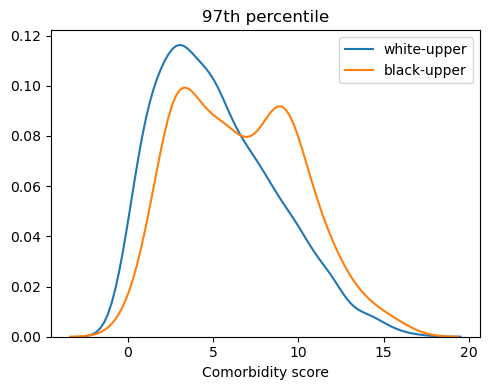

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.kdeplot(upperw_['gagne_sum_t'], label='white-upper', ax=ax)
sns.kdeplot(upperb_['gagne_sum_t'], label='black-upper', ax=ax)
# sns.kdeplot(lowerb_['gagne_sum_t'], label='black-lower', ax=ax)
ax.set(xlabel='Comorbidity score', title='97th percentile')
fig.tight_layout()

How the swapping works:
1. at a given percentile (e.g., 97th percentile) based on the risk score (cost algo)
2. identify whites who are above, identify blacks who are above and below cutoff
3. if the healthiest white-upper's comorbidity < sickest black-lower's comorbidity 
   (= if the healthist white-upper is healthier than the sickest black-lower)
4. remove the healthiest white (white-upper) 
5. and give this spot to the sickest black from black-below (move them to the black-upper)
6. check all blacks in black-below

In [12]:
while sb < lowerb.shape[0]:
    if upperw.iloc[sw]['gagne_sum_t'] < lowerb.iloc[sb]['gagne_sum_t']:
        switched_w = switched_w.append(upperw.iloc[sw])
        switched_b = switched_b.append(lowerb.iloc[sb])

        upperb = upperb.append(lowerb.iloc[sb])
        upperw = upperw.drop(upperw.index[sw])
        upperw = upperw.sort_values('gagne_sum_t')
        
        sb += 1
        switched_count += 1
    else:
        sb += 1
        switched_count = switched_count

Comparing the distribution of comorbidity score between before and after

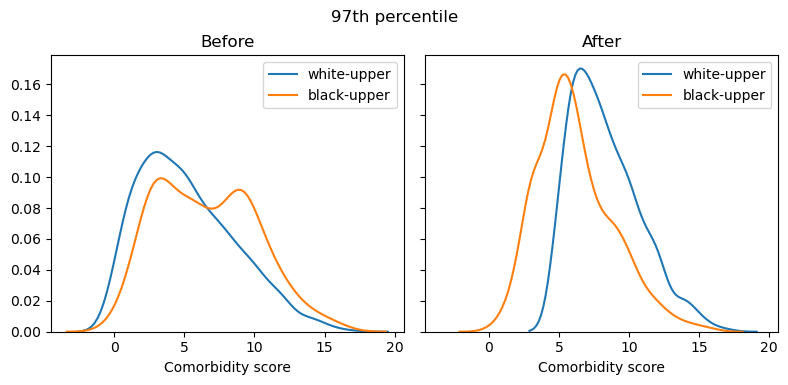

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
sns.kdeplot(upperw_['gagne_sum_t'], label='white-upper', ax=axes[0])
sns.kdeplot(upperb_['gagne_sum_t'], label='black-upper', ax=axes[0])
axes[0].set(xlabel='Comorbidity score', title='Before')

sns.kdeplot(upperw['gagne_sum_t'], label='white-upper', ax=axes[1])
sns.kdeplot(upperb['gagne_sum_t'], label='black-upper', ax=axes[1])
axes[1].set(xlabel='Comorbidity score', title='After')

fig.suptitle('97th percentile', x=0.5, y=0.95)
fig.tight_layout()